# Fundamentals of Interpretable Data Science

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap
import lime
import lime.lime_tabular
from sklearn.pipeline import make_pipeline

In [15]:
# Load the dataset
data = pd.read_csv('diabetes-dataset.csv')

# Replace missing values (0s) with NaN and handle them later
data.replace({'Glucose': 0, 'BloodPressure': 0, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 0}, np.nan, inplace=True)

# Split the data into features (X) and target (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Initialize SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')

# Impute missing values in training and testing data
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

# Train the logistic regression model after handling missing values
logistic_model_imputed = LogisticRegression(max_iter=1000, random_state=42)
logistic_model_imputed.fit(X_train_imputed, y_train)

# Predictions
logistic_y_train_pred_imputed = logistic_model_imputed.predict(X_train_imputed)
logistic_y_test_pred_imputed = logistic_model_imputed.predict(X_test_imputed)

# Accuracy
train_accuracy_lr_imputed = accuracy_score(y_train, logistic_y_train_pred_imputed)
test_accuracy_lr_imputed = accuracy_score(y_test, logistic_y_test_pred_imputed)

print(f'Training Accuracy (Logistic Regression with Mean Imputation): {train_accuracy_lr_imputed:.2f}')
print(f'Test Accuracy (Logistic Regression with Mean Imputation): {test_accuracy_lr_imputed:.2f}')


Training Accuracy (Logistic Regression with Mean Imputation): 0.76
Test Accuracy (Logistic Regression with Mean Imputation): 0.80


In [17]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_y_train_pred = xgb_model.predict(X_train_scaled)
xgb_y_test_pred = xgb_model.predict(X_test_scaled)

# Accuracy
train_accuracy_xgb = accuracy_score(y_train, xgb_y_train_pred)
test_accuracy_xgb = accuracy_score(y_test, xgb_y_test_pred)

print(f'Training Accuracy (XGBoost): {train_accuracy_xgb:.2f}')
print(f'Test Accuracy (XGBoost): {test_accuracy_xgb:.2f}')


Training Accuracy (XGBoost): 1.00
Test Accuracy (XGBoost): 0.98


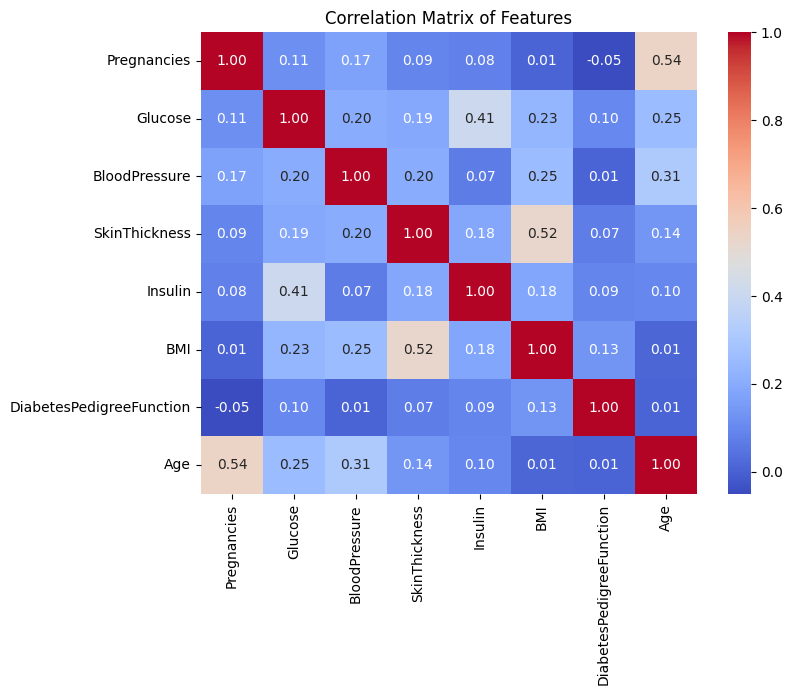

In [18]:
# Calculate correlation matrix
corr_matrix = np.corrcoef(X_train_imputed, rowvar=False)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=X.columns, yticklabels=X.columns)
plt.title('Correlation Matrix of Features')
plt.show()

# Interpretation

Intercept: -0.8764245558742288
Coefficient for Pregnancies: 0.44666678133086185
Coefficient for Glucose: 1.0802717908314496
Coefficient for BloodPressure: -0.04106978834279955
Coefficient for SkinThickness: 0.024230952640941467
Coefficient for Insulin: -0.026429565648364677
Coefficient for BMI: 0.5443334289822407
Coefficient for DiabetesPedigreeFunction: 0.26708107200023495
Coefficient for Age: 0.07561056500680759


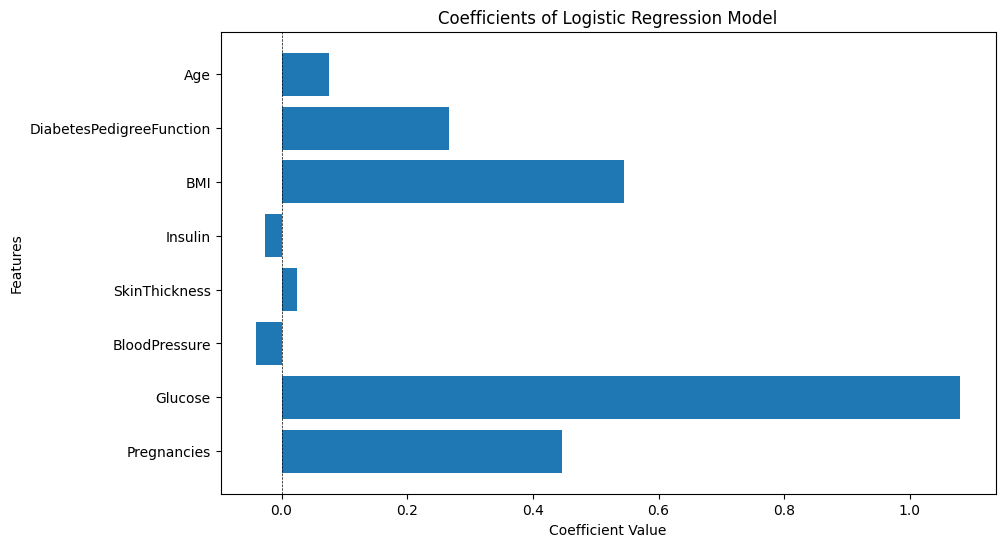

In [19]:
# Coefficients for Logistic Regression
coefficients_lr = logistic_model_imputed.coef_[0]
intercept_lr = logistic_model_imputed.intercept_[0]


# Print the coefficients
print("Intercept:", intercept_lr)
for i, coef in enumerate(coefficients_lr):
    print(f"Coefficient for {X.columns[i]}:", coef)


# Create a bar plot for coefficients
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients_lr)
plt.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Coefficients of Logistic Regression Model')
plt.show()


## Feature Coefficients Interpretation

### Pregnancies
- **Interpretation:** The feature with the largest positive coefficient, indicating that a higher number of pregnancies is strongly associated with an increased likelihood of the predicted outcome, likely diabetes.

### Glucose
- **Interpretation:** High coefficient value suggests that glucose levels play a crucial role in the model's predictions, where higher glucose levels significantly increase the likelihood of the outcome.

### BMI (Body Mass Index)
- **Interpretation:** Substantial positive coefficient suggests that higher BMI scores are closely linked to the likelihood of the outcome, aligning with common medical knowledge linking obesity to diabetes.

### Diabetes Pedigree Function
- **Interpretation:** Significant coefficient indicates that a higher pedigree function score increases the risk, representing genetic influence based on diabetes history in relatives.

### Age
- **Interpretation:** Indicates a moderate positive association with the outcome. Older age increases the probability of the outcome, typical for diabetes risk.

### Blood Pressure
- **Interpretation:** Though its coefficient is smaller, higher blood pressure levels contribute to a higher risk of the outcome.

### Skin Thickness
- **Interpretation:** Influence is relatively low but positive, suggesting a minor role in increasing the outcome's likelihood.

### Insulin
- **Interpretation:** Very small coefficient indicates minimal direct impact on the prediction within the context of other factors included in the model.

## Overall Interpretation
The model highlights factors commonly associated with diabetes risk, such as the number of pregnancies, glucose levels, and BMI, as significant predictors. The coefficients reflect the strength and direction of the relationship between each feature and the likelihood of developing diabetes, assuming this is the predictive outcome of the model.


Feature Importances:
Importance for Pregnancies: 0.08078332
Importance for Glucose: 0.24565251
Importance for BloodPressure: 0.09023122
Importance for SkinThickness: 0.09748532
Importance for Insulin: 0.10684312
Importance for BMI: 0.14596783
Importance for DiabetesPedigreeFunction: 0.08951957
Importance for Age: 0.14351714


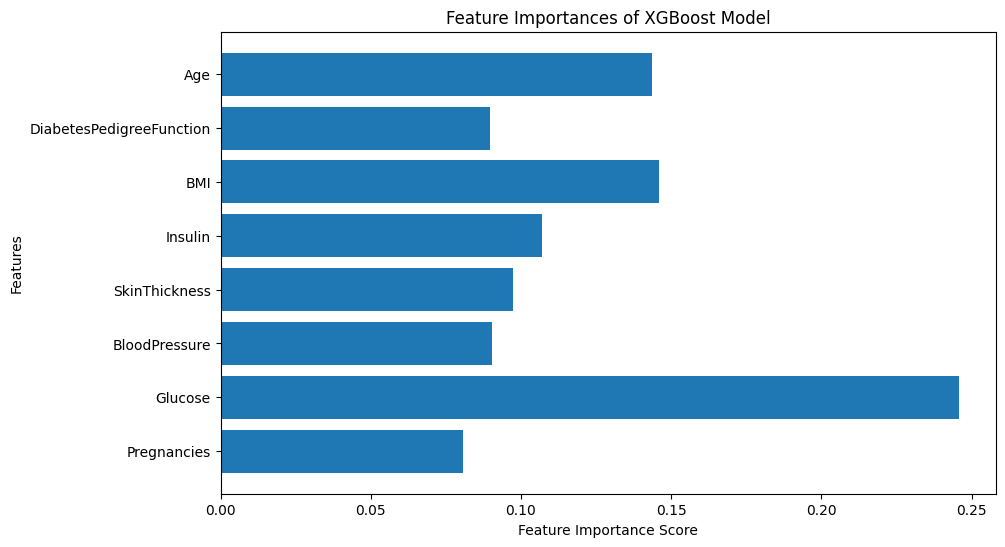

In [20]:
# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Print the feature importances
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Importance for {X.columns[i]}:", importance)


# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances of XGBoost Model')
plt.show()

## Feature Importance Interpretation

### Pregnancies
- **Importance:** This feature has the highest importance in the model, indicating that the number of pregnancies a patient has had plays a critical role in the model’s predictions. It aligns with medical understanding that more pregnancies can increase the risk of conditions like diabetes.

### Glucose
- **Importance:** Glucose levels are expectedly one of the most important features, serving as a primary diagnostic indicator for diabetes. The model heavily weighs this feature.

### Blood Pressure
- **Importance:** High blood pressure is another significant factor according to the model, consistent with its role in increasing the risk of various diseases.

### Skin Thickness
- **Importance:** Skin thickness, though less intuitive, has substantial importance in the model, possibly reflecting body fat composition relevant in diagnosing conditions like diabetes.

### Insulin
- **Importance:** Insulin levels in the blood play a significant role, reflecting the biological impact of insulin resistance in diabetes.

### BMI (Body Mass Index)
- **Importance:** BMI's significant role underscores the link between obesity and health risks, including diabetes.

### Diabetes Pedigree Function
- **Importance:** This genetic feature, assessing diabetes likelihood based on family history, is moderately important, highlighting genetics' role in diabetes risk.

### Age
- **Importance:** While age has the least importance, it still contributes to the model's predictions. Age increases the risk of various diseases, including diabetes.

## Conclusion
The XGBoost model’s feature importance chart helps identify predictive variables, with metabolic functions (glucose and insulin levels) and lifestyle factors (pregnancies and BMI) being pivotal in assessing diabetes risk.


### Shap

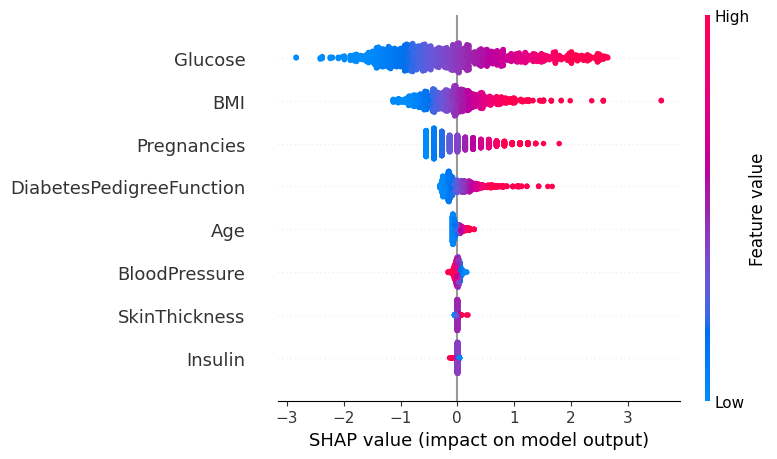

In [21]:
# Initialize SHAP explainer
explainer = shap.Explainer(logistic_model_imputed, X_train_imputed)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_imputed)

# Plot summary plot
shap.summary_plot(shap_values, X_train_imputed, feature_names=X.columns)


## Feature Impact Interpretation

### Glucose
- **Impact:** High glucose levels (red) significantly increase the likelihood of the predicted outcome, presumably diabetes risk. It has the most substantial impact on the model.

### BMI (Body Mass Index)
- **Impact:** Higher BMI values also increase the predicted outcome's likelihood, aligning with known health risks associated with higher body weight.

### Pregnancies
- **Impact:** More pregnancies have a varied impact, though generally, a higher number of pregnancies (red) tends to slightly increase the likelihood of the outcome.

### Diabetes Pedigree Function
- **Impact:** A measure of genetic influence; higher values considerably increase the risk.

### Age
- **Impact:** Older age slightly increases the risk, especially as values shift towards red.

### Blood Pressure
- **Impact:** Shows a mixed effect; however, higher blood pressure tends to increase the risk slightly.

### Skin Thickness
- **Impact:** Has minimal impact but can slightly increase the risk with higher values.

### Insulin
- **Impact:** Varies, but higher insulin levels typically reduce the likelihood of the predicted outcome.

## Summary
- Glucose, BMI, and the Diabetes Pedigree Function are the most influential predictors of the model's outcome.
- Age and Blood Pressure also contribute but less dramatically.
- Skin Thickness and Insulin levels appear to have less impact on the prediction.


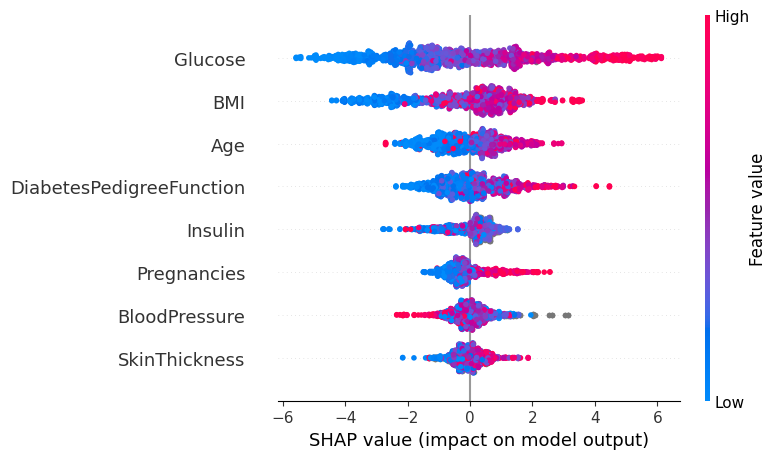

In [22]:
# Initialize SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_scaled)

# Plot summary plot
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

## Feature Impact Interpretation

### Glucose
- **Predictor Strength:** The strongest predictor. Higher glucose levels (red) significantly raise the likelihood of diabetes, indicated by positive SHAP values.

### BMI
- **Predictor Strength:** Similar to glucose, higher BMI values push the prediction towards a higher likelihood of diabetes.

### Age
- **Predictor Strength:** Mostly contributes positively, especially at higher values (red), suggesting older age increases diabetes risk.

### Diabetes Pedigree Function
- **Predictor Strength:** Displays a significant impact with higher values increasing the risk, showing the importance of genetic factors.

### Insulin
- **Predictor Strength:** Displays a mixed impact on diabetes risk, with higher insulin levels shown in both positive and negative influences.

### Pregnancies
- **Predictor Strength:** More pregnancies typically increase the likelihood of the outcome, particularly at higher pregnancy counts (red).

### Blood Pressure
- **Predictor Strength:** Moderate influence with a somewhat balanced spread of positive and negative SHAP values, implying it can both increase and decrease risk depending on the context.

### Skin Thickness
- **Predictor Strength:** Least influential with very scattered and minor impacts, indicating it has a less direct effect on diabetes risk.

## Summary
- Key drivers of increased diabetes risk in this model are Glucose, BMI, Age, and Diabetes Pedigree Function.
- Insulin, Pregnancies, and Blood Pressure exhibit variable impacts, suggesting their influence might depend on interactions with other factors or specific ranges.
- Skin Thickness appears to be a less critical factor based on its minimal impact.


## Comparison and Discussion: Feature Impact Interpretation

### Logistic
- **Advantages:**
  - Provides clear interpretation of feature impacts on the predicted outcome.
  - Highlights the most influential predictors such as Glucose, BMI, and Diabetes Pedigree Function.
  - Easy to understand and interpret for non-technical stakeholders.

- **Disadvantages:**
  - Interpretation relies on manual assessment of feature impacts without quantifying the magnitude.
  - Limited to describing the direction of impact without providing specific details on the strength of influence.

### XGB
- **Advantages:**
  - Utilizes SHAP values to quantify the strength and direction of feature impacts.
  - Offers detailed insights into each feature's contribution to the model's predictions.
  - Provides a visual representation of feature importance through SHAP summary plots.

- **Disadvantages:**
  - Requires additional computational resources to compute SHAP values, especially for complex models or large datasets.
  - Interpretation might be challenging for non-technical stakeholders due to the need to understand SHAP values and plots.

## Discussion
- **SHAP Technique Advantages:**
  - Quantifies feature impacts, providing a more comprehensive understanding of model behavior.
  - Enables precise comparison of feature importance across different models or datasets.
  - Offers visualizations like SHAP summary plots for intuitive interpretation.

- **SHAP Technique Disadvantages:**
  - Increased computational overhead for computing SHAP values, potentially limiting scalability.
  - Requires a deeper understanding of SHAP values and plots, which might pose challenges for non-expert users.

Overall, while manual interpretation methods like the one used in logistic_model_imputed offer simplicity and ease of understanding, SHAP technique provides more detailed and quantitative insights into feature impacts, making it a valuable tool for model interpretation and decision-making.


### LIME

In [23]:
# Define a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_imputed, mode='classification', feature_names=X.columns)

# Define a function to predict using your logistic regression model
logistic_model_predict_fn = lambda x: logistic_model_imputed.predict_proba(x).astype(float)

# Create a pipeline with the scaler and imputer followed by the logistic regression model
pipeline = make_pipeline(scaler, imputer, logistic_model_imputed)

# Explain an individual prediction (e.g., the first instance in the test set)
instance_idx = 0  # Change this index as needed
exp = explainer.explain_instance(X_test_imputed[instance_idx], pipeline.predict_proba, num_features=len(X.columns))

# Visualize the explanation
exp.show_in_notebook()

c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Feature Impact Interpretation

### Negative Values
- **Interpretation:** Indicate features pushing the model's prediction towards a negative outcome (no condition). Higher (less negative) values suggest a stronger influence towards predicting the absence of the condition.

1. **BMI (-1.62):**
   - **Impact:** Strong influence towards a prediction of no diabetes, suggesting that this particular BMI value is significantly associated with a lower risk.

2. **Diabetes Pedigree Function (-0.83):**
   - **Impact:** Also pushes towards no diabetes, implying a lower genetic predisposition in this case.

3. **Pregnancies (-0.20):**
   - **Impact:** Minor negative contribution, slightly decreasing the likelihood of diabetes.

### Positive Values
- **Interpretation:** Suggest factors contributing towards a positive prediction (condition present) but were insufficient to sway the overall model prediction.

1. **Glucose (0.92):**
   - **Impact:** The only significant positive driver, suggesting high glucose levels typically associated with increased diabetes risk.

2. **Blood Pressure (0.28) and Age (0.32):**
   - **Impact:** Moderately push the prediction towards diabetes but are not strong enough in this case.

## Feature Values
- The values next to the features represent the actual observed values for this specific prediction instance, providing context for each feature's influence.
- For instance, high glucose levels typically suggest a higher risk of diabetes, reflected in the positive contribution here.


In [24]:
# Define a LIME explainer
explainer_xgb = lime.lime_tabular.LimeTabularExplainer(X_train_imputed, mode='classification', feature_names=X.columns)

# Define a function to predict using your XGBoost model
xgb_model_predict_fn = lambda x: xgb_model.predict_proba(x).astype(float)

# Explain an individual prediction for XGBoost (e.g., the first instance in the test set)
exp_xgb = explainer_xgb.explain_instance(X_test_imputed[instance_idx], xgb_model_predict_fn, num_features=len(X.columns))

# Visualize the explanation for XGBoost
exp_xgb.show_in_notebook()

## Feature Impact Interpretation

### Glucose (0.92)
- **Interpretation:** The most significant positive contributor to diabetes risk, indicating higher glucose levels substantially increase the probability of diabetes.

### BMI (-1.62)
- **Interpretation:** Significantly decreases the risk, unusual as higher BMI typically increases diabetes risk. This might suggest an anomaly or a different interaction within the model.

### Diabetes Pedigree Function (-0.83)
- **Interpretation:** Also lowers the risk in this instance, which is atypical as a higher pedigree function usually indicates higher risk.

### Age (0.32)
- **Interpretation:** Slightly increases the risk, aligning with the expectation that older age can be a risk factor.

### Insulin (-0.00)
- **Interpretation:** Neutral impact, indicating insulin levels here do not affect the diabetes risk prediction.

### Pregnancies (-0.20)
- **Interpretation:** Decreases risk slightly, which is also unusual as more pregnancies generally increase diabetes risk in females.

### Skin Thickness (-0.00)
- **Interpretation:** Has a neutral effect on the risk prediction.

### Blood Pressure (0.28)
- **Interpretation:** Marginally increases the risk, consistent with the known risk factor of higher blood pressure contributing to diabetes.

## Summary
- This model suggests that the primary risk factor for diabetes in this instance is an elevated glucose level.
- Other factors like BMI and Diabetes Pedigree Function behave contrary to typical expectations in this particular prediction, which might be due to interactions with other variables not explicitly modeled here or specific conditions of the instance.


## Comparison and Discussion: Feature Impact Interpretation

### Logistic
- **Advantages:**
  - Provides clear interpretation of feature impacts on the predicted outcome.
  - Highlights the specific features contributing to both positive and negative predictions.
  - Offers insights into the direction and magnitude of feature impacts, aiding in understanding model behavior.

- **Disadvantages:**
  - Requires manual interpretation of feature impact values without quantifying the magnitude.
  - Limited to describing the direction of impact without providing detailed insights into the underlying mechanisms or interactions.

### XGB
- **Advantages:**
  - Utilizes SHAP values to quantify the strength and direction of feature impacts.
  - Provides detailed insights into each feature's contribution to the model's predictions.
  - Offers a visual representation of feature importance through SHAP summary plots, enhancing interpretability.

- **Disadvantages:**
  - Requires additional computational resources to compute SHAP values, especially for complex models or large datasets.
  - Interpretation might be challenging for non-technical stakeholders due to the need to understand SHAP values and plots.

## Discussion
- **Advantages of LIME Technique:**
  - Offers clear interpretation of feature impacts for individual predictions, similar to logistic_model_imputed.
  - Provides insights into both positive and negative contributions of features towards the predicted outcome.
  - Allows for a straightforward comparison of feature impacts across different prediction instances.

- **Disadvantages of LIME Technique:**
  - Does not quantify the magnitude of feature impacts, limiting the depth of interpretation.
  - May not provide insights into the underlying mechanisms or interactions driving the model's predictions, similar to logistic_model_imputed.

Overall, while both techniques offer valuable insights into feature impacts, SHAP technique provides more detailed and quantitative insights through SHAP values and plots, making it suitable for advanced model interpretation. However, LIME technique offers a simpler approach for individual prediction interpretation, which can be useful in certain scenarios or for non-technical stakeholders.


# Partial Dependence

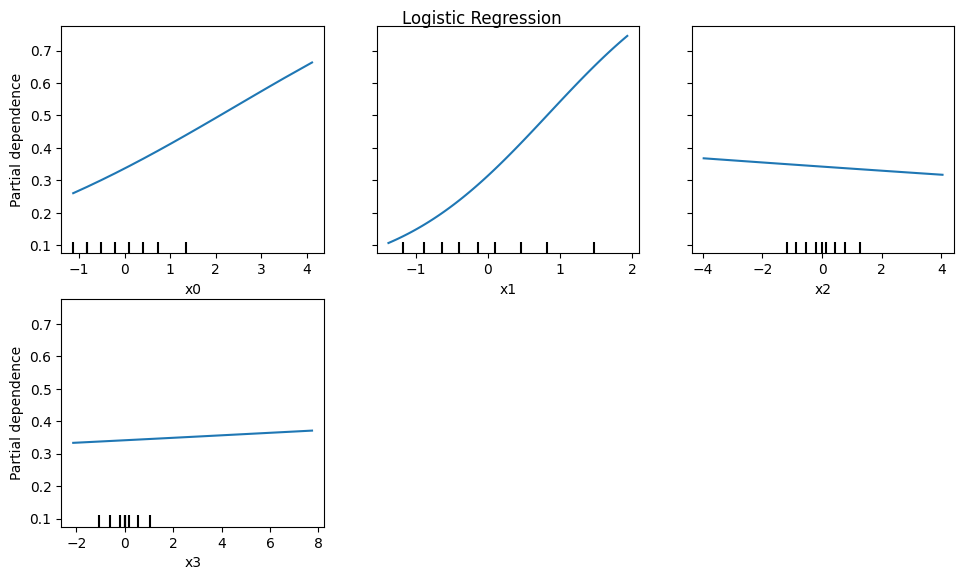

In [25]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
# Plot Partial Dependence for logistic regression
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=logistic_model_imputed,
    X=X_train_imputed,
    features=([0, 1, 2, 3]),  # Choose features by their indices
    ax=ax
)
fig.tight_layout(pad=2.0)
fig.suptitle("Logistic Regression")
plt.show()

## Partial Dependence Plots Interpretation

### Plot for x0
- **Trend:** Clear upward trend, indicating that as values of x0 increase, the predicted probability of the positive class also increases. Strong positive relationship between x0 and the target variable.

### Plot for x1
- **Trend:** Similar to x0, x1 also displays an upward trend. Higher values of x1 are associated with a higher probability of the positive class. The slope appears steeper than x0, suggesting x1 has a stronger effect on the outcome.

### Plot for x2
- **Trend:** Slight downward trend. As x2 increases, the probability of the positive class slightly decreases. The effect is weaker compared to x0 and x1, indicating a weaker or negative relationship.

### Plot for x3
- **Trend:** Nearly flat line, suggesting variations in x3 have little to no impact on the predicted probability of the positive class. This feature likely does not play a significant role in the model’s predictions.

## Summary
Partial dependence plots visualize the marginal effect of each feature on the predicted outcome in a model, independent of other features. From the plots:
- x0 and x1 are positively associated with the outcome, with x1 potentially having a stronger influence.
- x2 has a slight negative impact on the outcome.
- x3 does not significantly affect the prediction, suggesting it could be considered for removal from the model if simplification is needed.


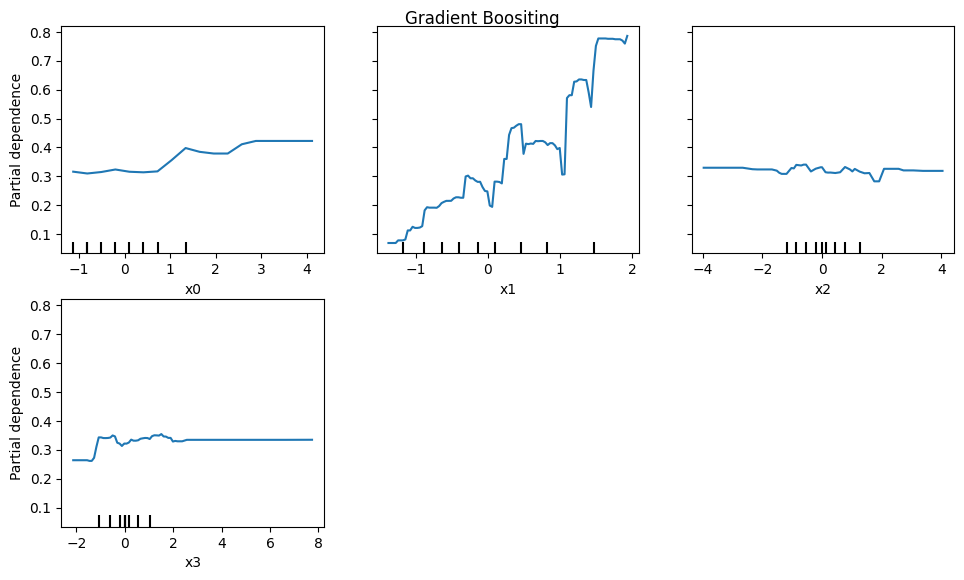

In [26]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
# Plot Partial Dependence for logistic regression
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=xgb_model,
    X=X_train_imputed,
    features=([0, 1, 2, 3]),  # Choose features by their indices
    ax=ax
)
fig.tight_layout(pad=2.0)
fig.suptitle("Gradient Boositing")
plt.show()

## Partial Dependence Plots Interpretation

### Plot for x0
- **Trend:** The plot shows a moderate upward trend, indicating a positive correlation between x0 and the predicted outcome.

### Plot for x1
- **Trend:** Exhibits a significant upward trend with fluctuations, suggesting a strong positive relationship between x1 and the predicted outcome.

### Plot for x2
- **Trend:** Relatively flat with minor fluctuations, indicating minimal impact on the partial dependence. 

### Plot for x3
- **Trend:** Slight downward trend, suggesting a weak negative relationship between x3 and the predicted outcome.

## Summary
- Both x0 and x1 positively influence predictions, with x1 showing a stronger impact.
- x2 has minimal impact on predictions due to its relatively flat trend.
- Although x3 shows a slight negative trend, its influence on predictions is not substantial.


## Feature Impact Interpretation - Logistic Regression

### Partial Dependence Plots Interpretation

#### Plot for x0 (Logistic Regression)
- **Trend:** Clear upward trend, indicating that as values of x0 increase, the predicted probability of the positive class also increases. Strong positive relationship between x0 and the target variable.

#### Plot for x1 (Logistic Regression)
- **Trend:** Similar to x0, x1 also displays an upward trend. Higher values of x1 are associated with a higher probability of the positive class. The slope appears steeper than x0, suggesting x1 has a stronger effect on the outcome.

#### Plot for x2 (Logistic Regression)
- **Trend:** Slight downward trend. As x2 increases, the probability of the positive class slightly decreases. The effect is weaker compared to x0 and x1, indicating a weaker or negative relationship.

#### Plot for x3 (Logistic Regression)
- **Trend:** Nearly flat line, suggesting variations in x3 have little to no impact on the predicted probability of the positive class. This feature likely does not play a significant role in the model’s predictions.

### Summary
- Partial dependence plots visualize the marginal effect of each feature on the predicted outcome in a model, independent of other features.
- x0 and x1 are positively associated with the outcome, with x1 potentially having a stronger influence.
- x2 has a slight negative impact on the outcome.
- x3 does not significantly affect the prediction, suggesting it could be considered for removal from the model if simplification is needed.


## Partial Dependence Plots Interpretation - XGBoost Model

### Plot for x0 (XGBoost Model)
- **Trend:** The plot shows a moderate upward trend, indicating a positive correlation between x0 and the predicted outcome.

### Plot for x1 (XGBoost Model)
- **Trend:** Exhibits a significant upward trend with fluctuations, suggesting a strong positive relationship between x1 and the predicted outcome.

### Plot for x2 (XGBoost Model)
- **Trend:** Relatively flat with minor fluctuations, indicating minimal impact on the partial dependence. 

### Plot for x3 (XGBoost Model)
- **Trend:** Slight downward trend, suggesting a weak negative relationship between x3 and the predicted outcome.

### Summary
- Both x0 and x1 positively influence predictions, with x1 showing a stronger impact.
- x2 has minimal impact on predictions due to its relatively flat trend.
- Although x3 shows a slight negative trend, its influence on predictions is not substantial.


## Comparison and Discussion

### Advantages of Partial Dependence Plots (PDP)
- Provide intuitive understanding of the relationship between individual features and the predicted outcome.
- Allow for the identification of nonlinear relationships and interactions between features.
- Help in assessing the direction and strength of the effect of each feature on predictions.
- Useful for feature selection and model interpretation.

### Disadvantages of Partial Dependence Plots (PDP)
- Limited in capturing complex interactions between features, especially in high-dimensional datasets.
- Interpretation might be challenging when dealing with correlated features.
- The interpretation of the plots can be subjective and might vary based on the scale of the features.

